# Word vectors from scratch
- read the text
- preprocess the text
- create data points
- create one-hot encoded matrices
- train neural network
- extract weights from the input layer

In [1]:
sentences = [
    "A dog is an example of a canine",
    "A cat is an example of a feline",
    "A gecko can be a pet.",
    "A cat is a warm-blooded feline.",
    "A gecko is a cold-blooded reptile.",
    "A dog is a warm-blooded mammal.",
    "A gecko is an example of a reptile.",
    "A mammal is warm-blooded.",
    "A reptile is cold-blooded.",
    "A cat is a mammal.",
]

In [2]:
import re
from typing import List, Tuple


def clean_text(
    text: str,
    punctuations: str = r"""!()-[]{};:'"\,<>./?@#$%^&*_~""",
    stop_words: List = ["the", "a", "an", "and", "is", "are", "in", "be", "can", "I", "have", "of", "example", "so", "both"],
) -> str:
    # Removing the punctuations
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")

    text = text.lower()
    text = " ".join([word for word in text.split() if word not in stop_words])
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [3]:
def create_word_pairs(text: List[str], window: int = 2) -> List[List[str]]:
    word_pairs = []
    for idx, word in enumerate(text):
        for w in range(window):
            if idx + 1 + w < len(text):
                pair = tuple([word] + [text[idx + 1 + w]])
                word_pairs.append(pair)
            if idx - w - 1 >= 0:
                pair = tuple([word] + [text[idx - w - 1]])
                word_pairs.append(pair)    
    return word_pairs

Let's then get the unique words for each and store them:

In [4]:
all_text = [clean_text(sentence).split() for sentence in sentences]
unique_words = sorted(set([word for text in all_text for word in text]))

In [5]:
all_text

[['dog', 'canine'],
 ['cat', 'feline'],
 ['gecko', 'pet'],
 ['cat', 'warmblooded', 'feline'],
 ['gecko', 'coldblooded', 'reptile'],
 ['dog', 'warmblooded', 'mammal'],
 ['gecko', 'reptile'],
 ['mammal', 'warmblooded'],
 ['reptile', 'coldblooded'],
 ['cat', 'mammal']]

Let's create one-hot encoded vectors for each word

In [6]:
def one_hot_encode(pairs: List[Tuple[str, str]], vocab: List[str]):
    n_words = len(vocab)
    
    # Create X and Y matrices
    X = []
    Y = []
    
    
    for pair in pairs:
        
        # Get main and context words
        main, ctx = pair  
        main_idx = vocab.index(main)
        ctx_idx = vocab.index(ctx)
        
        # Perform one-hot encoding
        x_row = [0] * n_words
        x_row[main_idx] = 1 
        X.append(x_row)
        y_row = [0] * n_words
        y_row[ctx_idx] = 1
        Y.append(y_row)
        
    return X, Y

In [7]:
all_word_pairs = []
for text in all_text:
    all_word_pairs += create_word_pairs(text)
#word_pairs = [create_word_pairs(text) for text in all_text]

In [8]:
X, y = one_hot_encode(pairs=all_word_pairs, vocab=unique_words)

Define our model

In [9]:
import torch
import torch.optim as optim
from torch import nn
torch.manual_seed(21)

In [10]:
input_dim, hidden_dim, output_dim = len(X[0]), 2, len(y[0])
model = nn.Sequential(
    nn.Linear(input_dim, hidden_dim),
    nn.Linear(hidden_dim, output_dim),
)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Convert our inputs and outputs into tensors
X_t = torch.FloatTensor(X)
y_t = torch.FloatTensor(y)

Train the model

In [11]:
for t in range(int(10e3)):
    # Compute forward pass and print loss
    y_pred = model(X_t)
    loss = loss_fn(y_pred, torch.argmax(y_t, dim=1))  # doesn't take one-hot encoded
    
    if t % 1000 == 99:
        print(t, loss.item())
    
    # Zero the gradients before running the backward pass
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Update weights using gradient descent
    optimizer.step()

99 2.347440004348755
1099 2.239278793334961
2099 2.130718469619751
3099 2.0155701637268066
4099 1.8986749649047852
5099 1.7920109033584595
6099 1.7015403509140015
7099 1.6277786493301392
8099 1.5648181438446045
9099 1.5043113231658936


In [12]:
name, weights = list(model.named_parameters())[0]

In [13]:
w = weights.data.tolist()

In [14]:
# Create embedding dict

embedding_dict = {}
for idx, word in enumerate(unique_words):
    embedding_dict[word] = (w[0][idx], w[1][idx])

In [15]:
embedding_dict

{'canine': (0.9686978459358215, 1.272706151008606),
 'cat': (0.8475805521011353, 0.20651397109031677),
 'coldblooded': (-1.4209543466567993, -0.9538927674293518),
 'dog': (0.15635372698307037, 0.5357027649879456),
 'feline': (-0.677571713924408, 1.3015227317810059),
 'gecko': (-1.021803379058838, -0.8113305568695068),
 'mammal': (0.37235257029533386, 1.2136141061782837),
 'pet': (-0.9806401133537292, -1.261562705039978),
 'reptile': (-0.5371686220169067, -1.061165452003479),
 'warmblooded': (1.1654094457626343, 0.20232778787612915)}

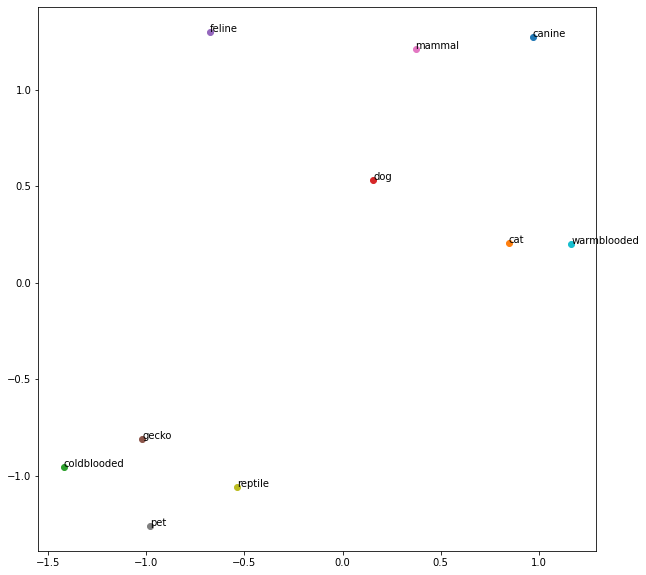

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))

for word in unique_words:
    coord = embedding_dict[word]
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, coord)